<a href="https://colab.research.google.com/github/psong5/Twitter-Hate-Speech-Detection-Using-Various-Machine-Learning-Models/blob/main/neural_network_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('/content/drive/My Drive/X_train_neural.csv')
X_test = pd.read_csv('/content/drive/My Drive/X_test_neural.csv')
y_train = pd.read_csv('/content/drive/My Drive/y_train_neural.csv')
y_test = pd.read_csv('/content/drive/My Drive/y_test_neural.csv')




In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Assuming X_train and X_test are Pandas DataFrames and you want to remove a column named 'Unnamed: 0'
X_train = X_train.drop('Unnamed: 0', axis=1)
X_test = X_test.drop('Unnamed: 0', axis=1)

In [ ]:
y_train = y_train.drop('Unnamed: 0', axis=1)
y_test = y_test.drop('Unnamed: 0', axis =1)

In [ ]:
X_train['text'] = X_train.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
X_test['text'] = X_test.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])

vocab_size = len(tokenizer.word_index) + 1


In [ ]:
X_train_padded = pad_sequences(X_train_seq, padding='post') # 'post' means to pad at the end of sequences
X_test_padded = pad_sequences(X_test_seq, maxlen=X_train_padded.shape[1], padding='post') # Use the same maxlen as X_train for consistency

# Convert lists to NumPy arrays for TensorFlow
X_train_array = np.array(X_train_padded)
X_test_array = np.array(X_test_padded)

In [ ]:
X_test[23] = np.nan
X_test[24] = np.nan

In [ ]:
# hote labels
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [ ]:
def recall_modified(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recalculated_recall = tp / (total_actual_positives + K.epsilon())
    return recalculated_recall

def precision_modified(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recalculated_precision = tp / (total_predicted_positives + K.epsilon())
    return recalculated_precision

def f1_score(y_true, y_pred):
    calculated_precision = precision_modified(y_true, y_pred)
    calculated_recall = recall_modified(y_true, y_pred)
    return 2 * ((calculated_precision * calculated_recall) / (calculated_precision + calculated_recall + K.epsilon()))


In [ ]:

output_dim = 200

# LSTM model architechture ... all of this is explained by the table at the very bottom
model = Sequential([
    Embedding(vocab_size, output_dim),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [ ]:
import tensorflow as tf

In [ ]:
model_history = model.fit(
    X_train_array,
    y_train,
    batch_size = 64,
    epochs=5,
    validation_data=(X_test_array, y_test)
)

Epoch 1/5
310/310 [==============================] - 65s 191ms/step - loss: 0.5028 - accuracy: 0.8320 - f1: 0.8113 - precision: 0.8441 - recall: 0.7884 - val_loss: 0.3619 - val_accuracy: 0.8866 - val_f1: 0.8840 - val_precision: 0.8963 - val_recall: 0.8723
Epoch 2/5
310/310 [==============================] - 63s 204ms/step - loss: 0.2847 - accuracy: 0.9086 - f1: 0.9089 - precision: 0.9253 - recall: 0.8935 - val_loss: 0.3383 - val_accuracy: 0.8864 - val_f1: 0.8857 - val_precision: 0.8981 - val_recall: 0.8739
Epoch 3/5
310/310 [==============================] - 59s 189ms/step - loss: 0.1964 - accuracy: 0.9318 - f1: 0.9321 - precision: 0.9432 - recall: 0.9216 - val_loss: 0.3650 - val_accuracy: 0.8888 - val_f1: 0.8893 - val_precision: 0.8950 - val_recall: 0.8837
Epoch 4/5
310/310 [==============================] - 58s 189ms/step - loss: 0.1373 - accuracy: 0.9566 - f1: 0.9564 - precision: 0.9608 - recall: 0.9521 - val_loss: 0.4734 - val_accuracy: 0.8824 - val_f1: 0.8816 - val_precision: 0.88

In [ ]:
y_pred = model.predict(X_test_array)

155/155 [==============================] - 2s 10ms/step


In [ ]:
print (y_test)
print (y_pred)

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print (y_test)
print (y_pred)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[2.7846934e-03 9.9711055e-01 1.0477608e-04]
 [6.2262558e-04 9.9935013e-01 2.7333010e-05]
 [1.2661618e-03 9.9868357e-01 5.0247811e-05]
 ...
 [6.3975586e-04 9.9933273e-01 2.7478947e-05]
 [3.2211545e-01 6.6344303e-01 1.4441613e-02]
 [1.7854389e-03 2.4369648e-03 9.9577761e-01]]
[1 1 1 ... 1 1 2]
[1 1 1 ... 1 1 2]


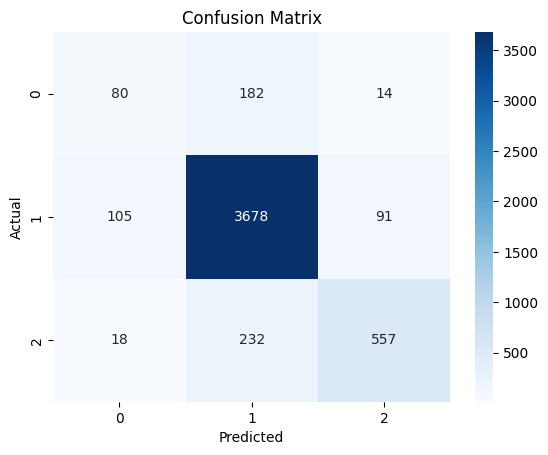

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['0', '1', '2']

cm = confusion_matrix(y_test, y_pred)
cm_df= pd.DataFrame(cm,index=categories,columns=categories)
sns.heatmap(data=cm_df, fmt='d', cmap='Blues', annot=True, xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         4919600   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 4996147 (19.06 MB)
Trainable params: 49961